# Time Series Linear Regression Algorithm

This algorithm is used to forecast FOREX prices for the USDJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hour


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")
import ta
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data

In [3]:
mt5.initialize()

True

In [4]:
# Fetching data from MetaTrade5 from 2010 to present using the custome function get_rates from the data.py file
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.420,120.440,120.330,120.390,262,30,0
2015-01-02 09:00:00,120.400,120.500,120.380,120.430,599,30,0
2015-01-02 10:00:00,120.440,120.480,120.340,120.340,832,30,0
2015-01-02 11:00:00,120.330,120.420,120.310,120.400,761,30,0
2015-01-02 12:00:00,120.410,120.470,120.370,120.430,484,30,0
...,...,...,...,...,...,...,...
2024-08-05 23:00:00,143.731,144.176,143.697,144.173,2079,18,0
2024-08-06 00:00:00,144.161,144.164,144.020,144.020,211,45,0
2024-08-06 01:00:00,144.018,144.844,143.602,144.758,2982,23,0


In [5]:
df = df[["close"]]
df

,close
time,
2015-01-02 08:00:00,120.390
2015-01-02 09:00:00,120.430
2015-01-02 10:00:00,120.340
2015-01-02 11:00:00,120.400
2015-01-02 12:00:00,120.430
...,...
2024-08-05 23:00:00,144.173
2024-08-06 00:00:00,144.020
2024-08-06 01:00:00,144.758


In [6]:
# Here I added a new column with the percent change between the close price and the previous close price
df["pct_change"] = df["close"].pct_change(1)
df

,close,pct_change
time,,
2015-01-02 08:00:00,120.390,NaN
2015-01-02 09:00:00,120.430,0.000332
2015-01-02 10:00:00,120.340,-0.000747
2015-01-02 11:00:00,120.400,0.000499
2015-01-02 12:00:00,120.430,0.000249
...,...,...
2024-08-05 23:00:00,144.173,0.003061
2024-08-06 00:00:00,144.020,-0.001061
2024-08-06 01:00:00,144.758,0.005124


## In the next section I started working on feature engineering and added more technical indicators

In [8]:
# Here were added columns with shifted values of the pct_change column
# The function "add_shifted_columns" was added to the data.py file 

df = data.add_shifted_columns(df,4, "pct_change")
df

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago
time,,,,,,
2015-01-02 08:00:00,120.390,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,120.430,0.000332,NaN,NaN,NaN,NaN
2015-01-02 10:00:00,120.340,-0.000747,0.000332,NaN,NaN,NaN
2015-01-02 11:00:00,120.400,0.000499,-0.000747,0.000332,NaN,NaN
2015-01-02 12:00:00,120.430,0.000249,0.000499,-0.000747,0.000332,NaN
...,...,...,...,...,...,...
2024-08-05 23:00:00,144.173,0.003061,0.002001,-0.003840,-0.001235,0.001598
2024-08-06 00:00:00,144.020,-0.001061,0.003061,0.002001,-0.003840,-0.001235
2024-08-06 01:00:00,144.758,0.005124,-0.001061,0.003061,0.002001,-0.003840


In [9]:
# A Simple Moving Average indicator was created and shifted one row so the outcome value of the previous time stamp
# make sence to predict the current value

df["SMA 7"] = df["close"].rolling(7).mean().shift(1)
df.head(10)

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago,SMA 7
time,,,,,,,
2015-01-02 08:00:00,120.39,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,120.43,0.000332,NaN,NaN,NaN,NaN,NaN
2015-01-02 10:00:00,120.34,-0.000747,0.000332,NaN,NaN,NaN,NaN
2015-01-02 11:00:00,120.40,0.000499,-0.000747,0.000332,NaN,NaN,NaN
2015-01-02 12:00:00,120.43,0.000249,0.000499,-0.000747,0.000332,NaN,NaN
2015-01-02 13:00:00,120.47,0.000332,0.000249,0.000499,-0.000747,0.000332,NaN
2015-01-02 14:00:00,120.62,0.001245,0.000332,0.000249,0.000499,-0.000747,NaN
2015-01-02 15:00:00,120.60,-0.000166,0.001245,0.000332,0.000249,0.000499,120.440000
2015-01-02 16:00:00,120.68,0.000663,-0.000166,0.001245,0.000332,0.000249,120.470000


In [10]:
# Here we are adding more technical indicators and delete the NaN values

df["SMA 21"] = df["close"].rolling(21).mean().shift(1)
df["STD 10"] = df["close"].rolling(10).std().shift(1)
df["STD 30"] = df["close"].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df["close"], window=21, fillna=False)
df["RSI"] = RSI.rsi() 

df.dropna(inplace=True)
df.head()

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago,SMA 7,SMA 21,STD 10,STD 30,RSI
time,,,,,,,,,,,
2015-01-05 14:00:00,120.15,-0.000915,-0.000748,0.001165,-0.001163,-0.000083,120.328571,120.356667,0.114819,0.128298,42.432619
2015-01-05 15:00:00,119.82,-0.002747,-0.000915,-0.000748,0.001165,-0.001163,120.294286,120.354762,0.134726,0.135879,34.656383
2015-01-05 16:00:00,119.48,-0.002838,-0.002747,-0.000915,-0.000748,0.001165,120.214286,120.336667,0.194276,0.170463,28.922381
2015-01-05 17:00:00,119.58,0.000837,-0.002838,-0.002747,-0.000915,-0.000748,120.088571,120.300952,0.298487,0.235143,32.377600
2015-01-05 18:00:00,119.64,0.000502,0.000837,-0.002838,-0.002747,-0.000915,119.978571,120.266667,0.340594,0.272396,34.387030


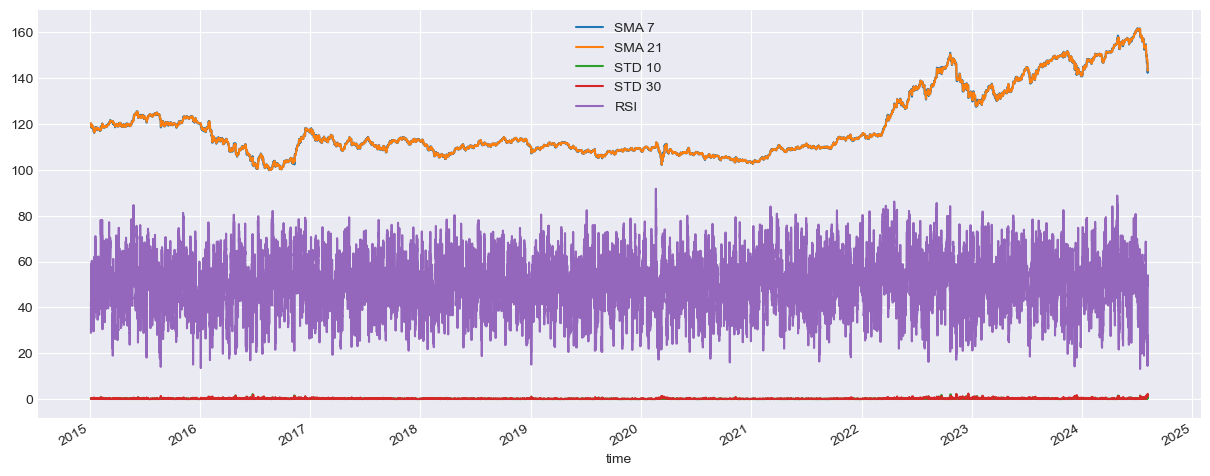

In [47]:
# Plotting the values for the indicators: SMA 7, SMA 21, STD 10, STD 30, and RSI

df[["SMA 7", "SMA 21", "STD 10", "STD 30", "RSI"]].plot(figsize=(15, 6));

# Machine Learning Section

In [13]:
# Splitting the data into features, labels, train and test sets

split = int(0.80 * len(df))

X = df.iloc[:,2:]
y = df["pct_change"]

X_train = X.iloc[:split]
y_train = y.iloc[:split]

X_test = X.iloc[split:]
y_test = y.iloc[split:]

In [87]:
# Here, the data is being standardized so all features have a similar scale, ensuring balanced weights in the ML model

from sklearn.preprocessing import StandardScaler

# Only the feature set (X) needs to be standardized, not the targets (labels)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_scaled)

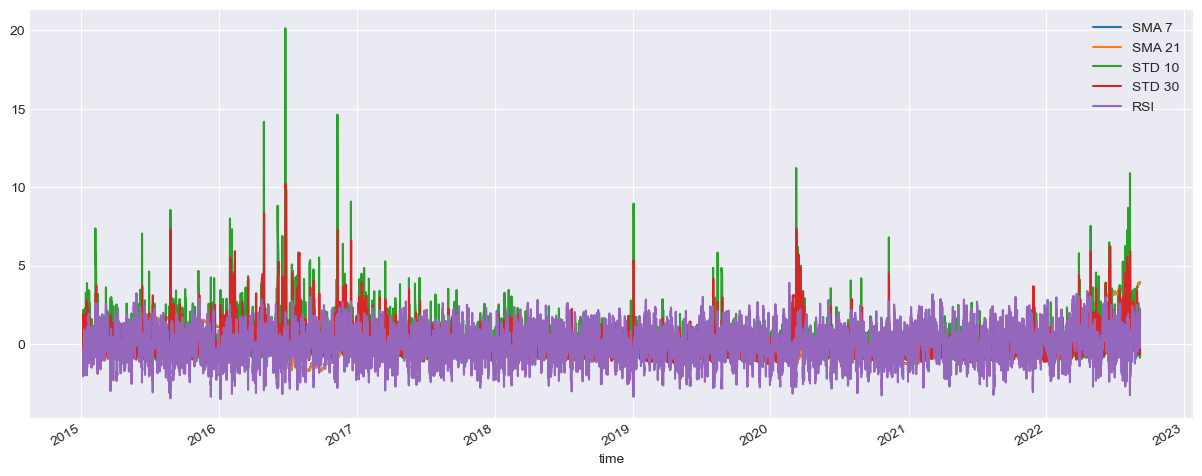

In [89]:
# Plotting the standarized data, Here number 4 is the "SMA 7" column and 8 corresponds to the "RSI" column

pd.DataFrame(X_train_scaled, index=X_train.index, columns=X.columns).iloc[:,4:].plot(figsize=(15, 6));

## Training and Fitting the data

In [92]:
from sklearn.linear_model import LinearRegression

In [94]:
regressor = LinearRegression()

# Training the data
regressor.fit(X_test_scaled, y_test)

# Making predictions
predictions = regressor.predict(X_test)

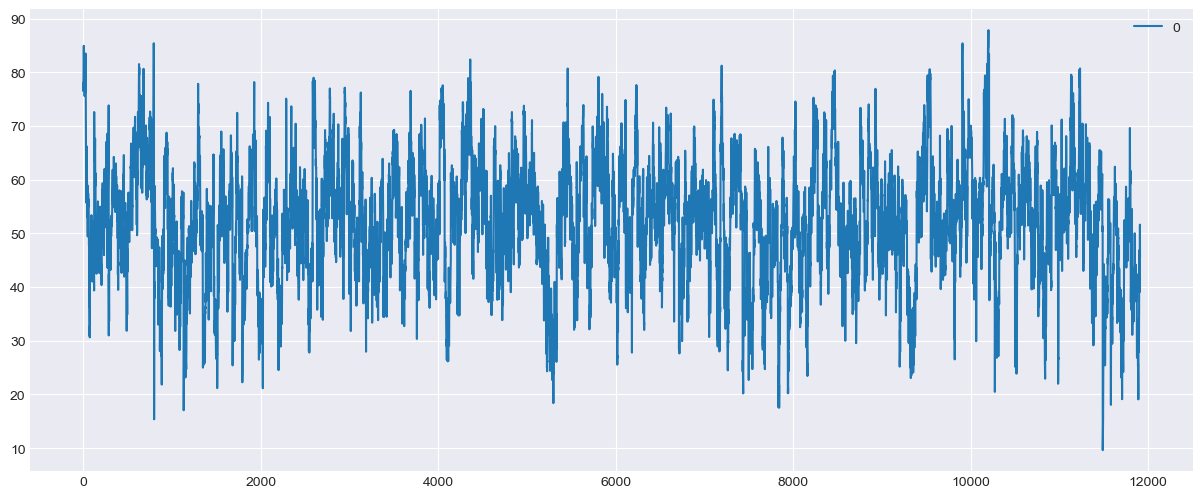

In [96]:
# Plot so visualized predictions go in both directions
pd.DataFrame(predictions).plot(figsize=(15,6));

In [98]:
# Here I took the percent change which are the labels and added the predictions

df_with_outcomes = df[["pct_change"]].iloc[split:]
df_with_outcomes["prediction"] = predictions
df_with_outcomes

,pct_change,prediction
time,,
2022-09-06 11:00:00,0.001060,78.052319
2022-09-06 12:00:00,-0.000176,76.494279
2022-09-06 13:00:00,0.000642,77.057162
2022-09-06 14:00:00,0.001079,78.305349
2022-09-06 15:00:00,0.003312,82.309137
...,...,...
2024-08-05 23:00:00,0.003061,42.592978
2024-08-06 00:00:00,-0.001061,40.261957
2024-08-06 01:00:00,0.005124,45.122392


In [100]:
df_with_outcomes["real_position"] = np.sign(df_with_outcomes["pct_change"])
df_with_outcomes["pred_position"] = np.sign(df_with_outcomes["prediction"])
df_with_outcomes

,pct_change,prediction,real_position,pred_position
time,,,,
2022-09-06 11:00:00,0.001060,78.052319,1.0,1.0
2022-09-06 12:00:00,-0.000176,76.494279,-1.0,1.0
2022-09-06 13:00:00,0.000642,77.057162,1.0,1.0
2022-09-06 14:00:00,0.001079,78.305349,1.0,1.0
2022-09-06 15:00:00,0.003312,82.309137,1.0,1.0
...,...,...,...,...
2024-08-05 23:00:00,0.003061,42.592978,1.0,1.0
2024-08-06 00:00:00,-0.001061,40.261957,-1.0,1.0
2024-08-06 01:00:00,0.005124,45.122392,1.0,1.0


In [102]:
# I don't shift the predictions her since all feature were already shifted by one, so predictions are made with yesterday's data

df_with_outcomes["returns"] = df_with_outcomes["pct_change"] * df_with_outcomes["pred_position"]
df_with_outcomes

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2022-09-06 11:00:00,0.001060,78.052319,1.0,1.0,0.001060
2022-09-06 12:00:00,-0.000176,76.494279,-1.0,1.0,-0.000176
2022-09-06 13:00:00,0.000642,77.057162,1.0,1.0,0.000642
2022-09-06 14:00:00,0.001079,78.305349,1.0,1.0,0.001079
2022-09-06 15:00:00,0.003312,82.309137,1.0,1.0,0.003312
...,...,...,...,...,...
2024-08-05 23:00:00,0.003061,42.592978,1.0,1.0,0.003061
2024-08-06 00:00:00,-0.001061,40.261957,-1.0,1.0,-0.001061
2024-08-06 01:00:00,0.005124,45.122392,1.0,1.0,0.005124


<Axes: xlabel='time'>

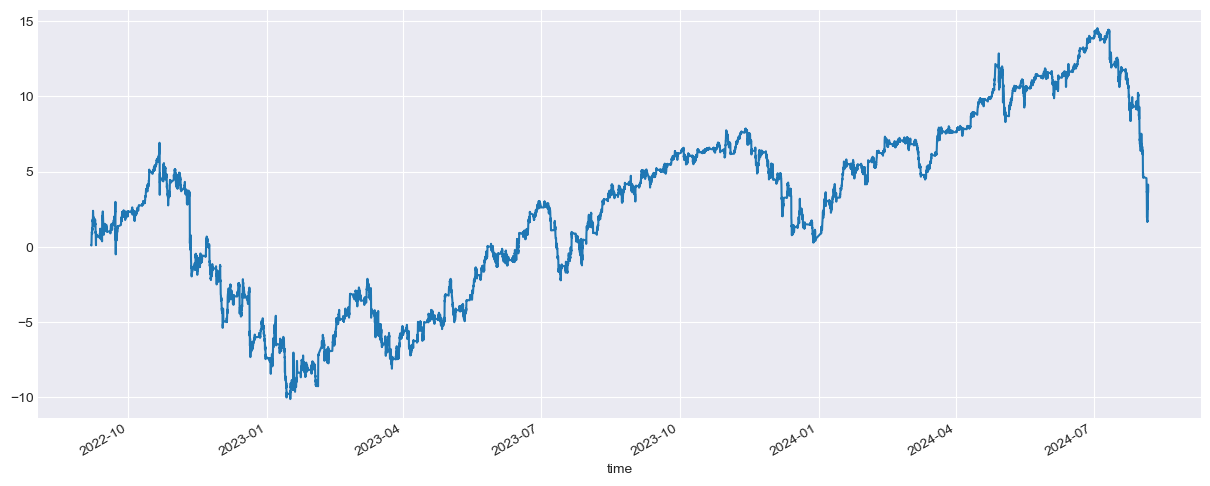

In [104]:
# Plotting the P&l from the Linear Regression Model

(df_with_outcomes["returns"].cumsum()*100).plot(figsize=(15,6))